## Text Analytics using NLP - Stan Lee (Web Scrapping - Twitter)
*Richard Abraham*

Using Twitter's rest API to extract relevant historical tweets

**Note:** Twitter limits the maximum age of searchable tweets to roughly a week. As such, the script can search for tweets posted up to just over a week ago. Twitter also limits the maximum number of tweets downloaded in every 15 minute interval.

In [ ]:
# Like before, in order to use this script you should register a data-mining application
# with Twitter. (Please follow the link in the 'README.md' file)

# After doing this you can copy and paste your unique consumer key,
# consumer secret, access token, and access secret into the load_api()
# function below.

In [ ]:
# Importing the relevant libraries
import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import sys

Before running the script, go to the main() function and edit the search criteria. Namely, enter the specifc search phrase/s

['Stan Lee','StanLee','Stanley Martin Lieber']

In [ ]:
def load_api():
    ''' Function that loads the twitter API after authorizing the user. '''

    access_token = "1058460595823898624-......."
    access_token_secret = "1WEXnY90QqgojwwjWyHIx-......."
    consumer_key = "hjyl9h70XUVH2-......."
    consumer_secret = "UPdbm6nMcgqPSXifM7wer-......."
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    return tweepy.API(auth)

In [ ]:
def tweet_search(api, query, max_tweets, max_id, since_id, geocode):
    ''' Function that takes in a search string 'query', the maximum
        number of tweets 'max_tweets', and the minimum (i.e., starting)
        tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
                                    max_id=str(max_id-1))
#                                    geocode=geocode)
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id

In [ ]:
def get_tweet_id(api, date='', days_ago=9, query='a'):
    ''' Function that gets the ID of a tweet. This ID can then be
        used as a 'starting point' from which to search. The query is
        required and has been set to a commonly used word by default.
        The variable 'days_ago' has been initialized to the maximum
        amount we are able to search back in time (9).'''

    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id

In [ ]:
def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')

In [ ]:
def main():
    ''' This is a script that continuously searches for tweets
        that were created over a given number of days. The search
        dates and search phrase can be changed below. '''



    ''' search variables: '''
    search_phrases = ['Stan Lee','StanLee','Stanley Martin Lieber']
    time_limit = 1.5                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be
                                               # iterated over) - maximum is 100
    min_days_old, max_days_old = 7, 9          # search limits e.g., from 7 to 8
                                               # gives current weekday from last week,
                                               # min_days_old=0 will search from right now
#     USA = '39.8,-95.583068847656,2500km'     # this geocode includes nearly all American
                                               # states (and a large portion of Canada)
# The issue here is a vast majority of the tweets are not geocoded and will therefore be excluded.
    

    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = load_api()
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)
        


        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id,
                                          geocode=USA)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break
                        
if __name__ == "__main__":
    main()

After each call of tweet_search() in the main program, we append the new tweets to a file in JSON format. The resulting JSON file can easily (although not necessarily quickly) be read and converted to a Pandas dataframe for analysis.

[This article explains the above steps and more in great detail](https://galeascience.wordpress.com/2016/03/18/collecting-twitter-data-with-python/)

**After extracting and storing the relevant historical tweets, we perform simular operations for sentiment analysis as before**

In [1]:
# Importing other packages
import re
from textblob import TextBlob as tb
import json
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tweets_data_path = 'C:/Users/Admin/Desktop/NLP Project/historical_twitter_data.txt'
tweets_data = []

tweets_file = open(tweets_data_path, "r")

for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

Loaded approximately ~577746 tweets

In [7]:
# Sample tweet
tweets_data[571745]

{'fullname': 'Daniel Kajdas',
 'html': '<p class="TweetTextSize js-tweet-text tweet-text" data-aria-label-part="0" lang="en">Not enough room for all the super heroes on this board. <strong>Stan Lee</strong> taught me we can all be heroes and we are all super. Excelsior.  <a class="twitter-hashtag pretty-link js-nav" data-query-source="hashtag_click" dir="ltr" href="/hashtag/ripstanlee?src=hash"><s>#</s><b>ripstanlee</b></a><a class="twitter-timeline-link u-hidden" data-pre-embedded="true" dir="ltr" href="https://t.co/EKFt2huPfw">pic.twitter.com/EKFt2huPfw</a></p>',
 'id': '1062069937764814853',
 'likes': 2,
 'replies': 0,
 'retweets': 0,
 'text': 'Not enough room for all the super heroes on this board. Stan Lee taught me we can all be heroes and we are all super. Excelsior.  #ripstanleepic.twitter.com/EKFt2huPfw',
 'timestamp': '2018-11-12T19:49:40',
 'url': '/98Dangrees/status/1062069937764814853',
 'user': '98Dangrees'}

In [8]:
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
#tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
#tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data))

In [9]:
# Getting other relevant information from tweet

tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split(" ")))
tweets['ID'] = list(map(lambda tweet: tweet['id'], tweets_data))
#tweets['Location'] = list(map(lambda tweet: tweet['user']['location'], tweets_data))
tweets['created_at'] = list(map(lambda tweet: tweet['timestamp'], tweets_data))
#tweets['Source'] = list(map(lambda tweet: tweet['source'], tweets_data))
tweets['Likes'] = list(map(lambda tweet: tweet['likes'], tweets_data))
#tweets['RTs'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))

In [11]:
tweets.head()

,text,word_count,ID,created_at,Likes
0,@MoonsharkMobile I'm destroying Obliterators a...,11,1061770100515180544,2018-11-11T23:58:13,0
1,Mr stand let u r awesome sir king ur awesome t...,25,1061759677464276992,2018-11-11T23:16:48,0
2,Ohhhh a hard one uhhhh I'd pick Stan lee https...,10,1061759564213821440,2018-11-11T23:16:21,2
3,Trump needs to tone it down with this fandom o...,23,1061759422060548098,2018-11-11T23:15:47,0
4,WHY DID NO ONE TELL ME THAT STAN LEE WAS IN TH...,16,1061759281526198279,2018-11-11T23:15:13,1


In [12]:
# Converting to datetime
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

### EXPLORATORY DATA ANALYSIS

In [13]:
# Average word count
tweets['word_count'].mean()

16.025834882456998

In [14]:
# Sentiment Analysis : showing first 5 tweets - before cleaning/processing data
tweets['text'][:5].apply(lambda x: tb(x).sentiment)

#returns a tuple representing polarity and subjectivity of each tweet. Here, we only extract polarity as it 
#indicates the sentiment as value nearer to 1 meaning a positive sentiment and values nearer to -1 meaning a negative sentiment.

0                                   (-0.2, 0.0)
1     (0.38571428571428573, 0.5071428571428571)
2     (-0.2916666666666667, 0.5416666666666666)
3    (-0.15555555555555559, 0.2888888888888889)
4                                    (0.0, 0.0)
Name: text, dtype: object

In [15]:
# Most liked tweet

fav_max = np.max(tweets['Likes'])
#rt_max  = np.max(tweets['RTs'])

fav = tweets[tweets.Likes == fav_max].index[0]
#rt  = tweets[tweets.RTs == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(tweets['text'][fav]))
print("Number of likes: {}".format(fav_max))

# Max RTs:
#print("The tweet with more retweets is: \n{}".format(tweets['text'][rt]))
#print("Number of retweets: {}".format(rt_max))

The tweet with more likes is: 
pic.twitter.com/dTdDjRvXbs
Number of likes: 1813314


Saving '../svg_filter_pie.svg'


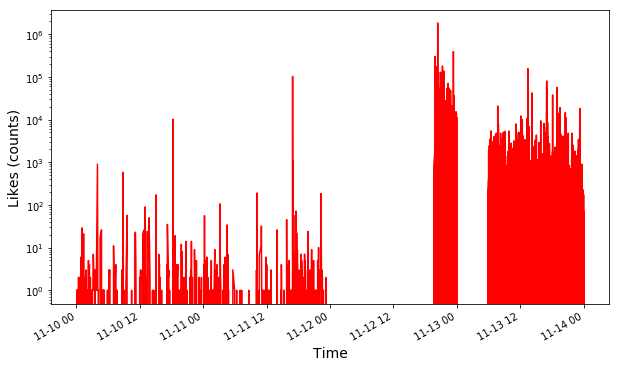

In [16]:
# Creating a Time Series chart showing Number of Likes vs Created_at (Date)

tfav = pd.Series(data=tweets['Likes'].values, index=tweets['created_at'])
tfav.plot(figsize=(10,6), color='r')
plt.yscale('log')
plt.xlabel('Time', fontsize = 14)
plt.ylabel("Likes (counts)", fontsize = 14)
#from io import BytesIO
#f = BytesIO()
plt.savefig('test.png', format="png")

- We can clearly see a spike in Twitters activity immediately following the death of Stan Lee

In [18]:
# Table showing Location for top 15 tweets in terms of number of Likes
top_likes=pd.DataFrame(tweets.nlargest(15, 'Likes'))
top_likes.head()

,text,word_count,ID,created_at,Likes
459479,pic.twitter.com/dTdDjRvXbs,1,1062078268319268864,2018-11-12 20:22:46,1813314
193496,"Thanks for everything Stan Lee! What a life, s...",33,1062123061397188609,2018-11-12 23:20:45,387175
550989,"Today, we pause and reflect with great sadness...",15,1062071197343592448,2018-11-12 19:54:40,300787
555862,We’ve lost a creative genius. Stan Lee was a p...,40,1062070890358288388,2018-11-12 19:53:27,262331
341514,"""Stan Lee was racist"". pic.twitter.com/QmquV88tSa",5,1062091862796894208,2018-11-12 21:16:47,177090


In [19]:
# Top liked tweets
for i in top_likes.head(10)['text']:
    print (i)

pic.twitter.com/dTdDjRvXbs
Thanks for everything Stan Lee! What a life, so well lived. I consider myself extraordinarily lucky to have gotten to meet you and to have played in the world you created. 
 pic.twitter.com/ryUjG7PL8D
Today, we pause and reflect with great sadness on the passing of Stan Lee: https://www.marvel.com/remembering_stan_lee …pic.twitter.com/eOBdZAqdZ0
We’ve lost a creative genius. Stan Lee was a pioneering force in the superhero universe. I’m proud to have been a small part of his legacy and .... to have helped bring one of his characters to life. #StanLee #Wolverinepic.twitter.com/iOdefi7iYz
"Stan Lee was racist". pic.twitter.com/QmquV88tSa
Born before Edwin Hubble discovered the expanding universe, he ultimately created an expanding universe of his own - one of scientifically literate superheroes such as Spider-Man , The Hulk, Iron Man, & Black Panther.
Stan Lee RIP: 1922 - 2018
RIP my friend. Thank you for the incredible adventures your stories took all of us on

### SENTIMENT ANALYSIS

Data cleaning/ Pre-processing

In [20]:
# Importing nltk, re packages for preprocessing tweets
import nltk
#import re
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [21]:
# 10 most common words before preprocessising
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:10]
freq

Stan    396785
Lee     239532
the     163410
a       161754
to      120097
and     116988
of      105730
de      100459
…        95319
you      93276
dtype: int64

In [22]:
# function to preprocess dataset
def preprocess(text_data):
    preprocessed_text=[]
    for text in text_data:
        #regext to remove RT retweets
        text=re.sub('RT'," ",text)
        #regex to remove punctuations,hashtags,@usermentions,URLs and convert to lowercase
        text=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).lower()
        #regex to remove numbers
        text=re.sub("\d+", " ", text)
        preprocessed_text.append(text)
    return preprocessed_text

In [23]:
tweets_text=tweets['text'].tolist()
preprocessed_set=preprocess(tweets_text)

In [24]:
# removing stop words
processed_text = pd.Series(preprocessed_set)
tweets['text'] = processed_text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweets['text'].head()

0                 destroying obliterators saving world
1    mr stand let u r awesome sir king ur awesome t...
2                   ohhhh hard one uhhhh pick stan lee
3    trump needs tone fandom putin like geek comicc...
4    one tell stan lee princess diaries pic twitter...
Name: text, dtype: object

In [25]:
# common words after general/basic preprocessing
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:10]
freq

stan       480543
lee        470564
com        129382
twitter    125904
rip        114782
de         104060
pic         93437
marvel      90626
stanlee     87828
que         61752
dtype: int64

In [26]:
# common words removal
freq = list(freq.index)
tweets['text'] = tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#tweets['text'].head()

In [27]:
# displaying rare words
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[-10:]
freq

vuoooycjnh    1
eqcltgfejj    1
avorio        1
khwtgzjdqm    1
oplyz         1
kqdpjt        1
khbl          1
pertorie      1
oalbfejzdh    1
ssrnoiixz     1
dtype: int64

In [28]:
# removing rare words
freq = list(freq.index)
tweets['text'] = tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#tweets['text'].head()

In [29]:
tweets_text=tweets['text'].tolist()

In [30]:
def tokenizeit(text_data):
    tokenized_text=[]
    for text in text_data:
        #tokenize the text
        tokenized=nltk.word_tokenize(text)
        #remove stop words
        tokenized_text.append(" ".join(list(x for x in tokenized if x not in stop)))
    return tokenized_text

In [31]:
tokenized_tweets=tokenizeit(tweets_text)
tokenized_tweets[:5]

['destroying obliterators saving world',
 'mr stand let u r awesome sir king ur awesome turkey sir wait lol excuse writing sir big fan well small haha',
 'ohhhh hard one uhhhh pick',
 'trump needs tone fandom putin like geek comiccon geeking meeting',
 'one tell princess diaries dsen ywer']

In [32]:
# Lemmatization
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
word_lem=WordNetLemmatizer()
tweets_cleaned = [" ".join(word_lem.lemmatize(token) for token in sentence.split(" ")) for sentence in tokenized_tweets]
tweets_cleaned[:5]

['destroying obliterator saving world',
 'mr stand let u r awesome sir king ur awesome turkey sir wait lol excuse writing sir big fan well small haha',
 'ohhhh hard one uhhhh pick',
 'trump need tone fandom putin like geek comiccon geeking meeting',
 'one tell princess diary dsen ywer']

In [33]:
processed_tweets = pd.Series(tweets_cleaned)

# Sentiment analysis
tweets['sentiment'] = processed_tweets.apply(lambda x: tb(x).sentiment[0] )
tweets[['text','sentiment']].head()

,text,sentiment
0,destroying obliterators saving world,-0.200000
1,mr stand let u r awesome sir king ur awesome t...,0.385714
2,ohhhh hard one uhhhh pick,-0.291667
3,trump needs tone fandom putin like geek comicc...,0.000000
4,one tell princess diaries dsen ywer,0.000000


In [34]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] < 0]

In [35]:
# We print percentages:

print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(tweets['text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(tweets['text'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(tweets['text'])))

Percentage of positive tweets: 32.2408117061823%
Percentage of neutral tweets: 59.782672662381046%
Percentage de negative tweets: 7.976515631436652%


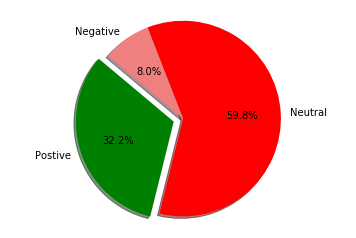

In [38]:
# Data to plot
labels = 'Postive', 'Neutral', 'Negative'
sizes = [(len(pos_tweets)/len(tweets['text'])),(len(neu_tweets)/len(tweets['text'])),(len(neg_tweets)/len(tweets['text']))]
colors = ['green', 'red', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
#plt.show()
plt.savefig('test1.png', format="png")